# 対数変換 (LightGBM)

Predicting Road Accident Risk (Playground Series - Season 5, Episode 10)

https://www.kaggle.com/competitions/playground-series-s5e10/overview

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from utils import check_df

## パラメータ設定

In [2]:
class CFG:
    exp_name = "exp06"
    seed = 123
    n_splits = 5

    # LightGBM parameters
    num_leaves = 16
    max_depth = -1
    learning_rate = 0.1

## データ読み込み

In [3]:
class Paths:
    p = "./input/"
    train = p + "train.csv"
    test = p + "test.csv"
    sample = p + "sample_submission.csv"
    submission = f"./output/{CFG.exp_name}.csv"

In [4]:
train = pd.read_csv(Paths.train)
test = pd.read_csv(Paths.test)
train.shape, test.shape

((517754, 14), (172585, 13))

In [5]:
if False:
    display(check_df(train))
    display(check_df(test))

## 特徴量エンジニアリング

In [6]:
def feature_engineering(df):
    df = df.drop(columns=["id"])
    # カテゴリ変数の処理
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in cat_cols:
        df[col] = df[col].astype("category")

    # bool型をint型に変換
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
    for col in bool_cols:
        df[col] = df[col].astype(int)

    # 目的変数の対数変換
    target = "accident_risk"
    if target in df.columns:
        df[target] = np.log1p(df[target])

    # TODO: 追加の特徴量エンジニアリングをここに実装

    return df

In [7]:
train_processed = feature_engineering(train)
test_processed = feature_engineering(test)

In [8]:
# データ分割
target = "accident_risk"
x_train = train_processed.drop(columns=[target])
y_train = train_processed[target]
x_test = test_processed.copy()

In [9]:
if False:
    train[target].hist(bins=50)

## クロスバリデーション

In [10]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": CFG.learning_rate,
    "num_leaves": CFG.num_leaves,
    "n_estimators": 100000,
    "random_state": CFG.seed,
    "verbose": -1,
}

In [11]:
cv = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)

y_test_pred = np.zeros(len(x_test))
metrics = []
imp = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
    print("=" * 10, f"Fold {fold + 1}", "=" * 10)
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params)

    model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        eval_metric="rmse",
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(100),
        ],
    )

    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    # y_test_pred += model.predict(x_test) / CFG.n_splits
    y_test_pred += np.expm1(model.predict(x_test)) / CFG.n_splits

    rmse_tr = np.sqrt(mean_squared_error(np.expm1(y_tr), np.expm1(y_tr_pred)))
    rmse_va = np.sqrt(mean_squared_error(np.expm1(y_va), np.expm1(y_va_pred)))

    metrics.append([fold + 1, rmse_tr, rmse_va])

    _imp = pd.DataFrame(
        {
            "feature": x_train.columns,
            "importance": model.feature_importances_,
            "fold": fold + 1,
        }
    )
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

========== Fold 1 ==========
[100]	training's rmse: 0.0419916	valid_1's rmse: 0.0419911
[200]	training's rmse: 0.0418198	valid_1's rmse: 0.0418798
[300]	training's rmse: 0.041716	valid_1's rmse: 0.0418335
[400]	training's rmse: 0.0416399	valid_1's rmse: 0.0418179
[500]	training's rmse: 0.0415585	valid_1's rmse: 0.0418008
[600]	training's rmse: 0.0414917	valid_1's rmse: 0.0417928
[700]	training's rmse: 0.0414288	valid_1's rmse: 0.0417816
[800]	training's rmse: 0.041374	valid_1's rmse: 0.0417796
[900]	training's rmse: 0.0413206	valid_1's rmse: 0.0417769
[1000]	training's rmse: 0.0412717	valid_1's rmse: 0.0417799
========== Fold 2 ==========
[100]	training's rmse: 0.0419555	valid_1's rmse: 0.0421808
[200]	training's rmse: 0.041788	valid_1's rmse: 0.0420745
[300]	training's rmse: 0.0416793	valid_1's rmse: 0.042023
[400]	training's rmse: 0.0415889	valid_1's rmse: 0.0419956
[500]	training's rmse: 0.0415195	valid_1's rmse: 0.0419783
[600]	training's rmse: 0.041458	valid_1's rmse: 0.0419706
[7

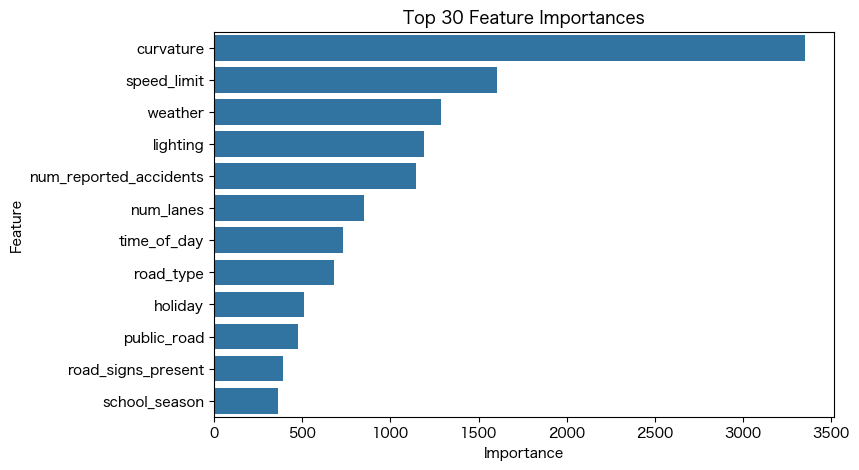

In [12]:
imp = imp.groupby("feature")["importance"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=imp.head(30).values, y=imp.head(30).index)
plt.title("Top 30 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [13]:
metrics_array = np.array(metrics)

print(
    "[cv ] tr: {:.5f} ± {:.5f}, va: {:.5f} ± {:.5f}".format(
        metrics_array[:, 1].mean(),
        metrics_array[:, 1].std(),
        metrics_array[:, 2].mean(),
        metrics_array[:, 2].std(),
    )
)

[cv ] tr: 0.05548 ± 0.00009, va: 0.05612 ± 0.00006


## 予測・提出

In [14]:
df_submit = pd.DataFrame(
    {
        "id": test["id"],
        "accident_risk": y_test_pred,
    }
)
df_submit.to_csv(Paths.submission, index=False)